<a href="https://colab.research.google.com/github/dgutiluns/water-anomaly-ca/blob/main/cleaning_sample_and_streamcat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from google.colab import drive

# Cleaning + Preprocessing

In [2]:
drive.mount('/content/drive')


path = '/content/drive/MyDrive/Year 3 Berk/Data Discovery Group Folder/Data/sample_with_streamcat.csv'
akansha_path = '/content/drive/MyDrive/sample_with_streamcat.csv' # I CHANGED THE PATH OF THIS DATASET CAUSE I HAD TO RUN IT AGAIN SO MAKE SURE YOU MATCH THE UPDATED VERSION
df = pd.read_csv(path)
df


Mounted at /content/drive


/tmp/ipython-input-1540763434.py:6: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,_id,Program,ParentProject,Project,StationName,StationCode,SampleDate,CollectionTime,LocationCode,CollectionDepth,...,prism_norm_8110.precip8110ws,prism_norm_8110.tmean8110ws,prism_norm_8110.tmax8110ws,prism_norm_8110.tmin8110ws,wetness.wetindexws,wetness.wetindexcat,runoff.runoffws,runoff.runoffcat,landfire_veg.pctnonagintrodmanagvegws,landfire_veg.pctnonagintrodmanagvegcat
0,1,Proposition 84,Prop84-City of San Diego,City of San Diego Hypolimnetic Oxygenation System,HGA,HGA,2017-04-18T00:00:00,00:00,Not Recorded,0.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
1,2,Proposition 84,Prop84-City of San Diego,City of San Diego Hypolimnetic Oxygenation System,HGA,HGA,2017-04-18T00:00:00,00:00,Not Recorded,3.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
2,3,Proposition 84,Prop84-City of San Diego,City of San Diego Hypolimnetic Oxygenation System,HGA,HGA,2017-04-18T00:00:00,00:00,Not Recorded,6.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
3,4,Proposition 84,Prop84-City of San Diego,City of San Diego Hypolimnetic Oxygenation System,HGA,HGA,2017-04-18T00:00:00,00:00,Not Recorded,9.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
4,5,Proposition 84,Prop84-City of San Diego,City of San Diego Hypolimnetic Oxygenation System,HGA,HGA,2017-04-18T00:00:00,00:00,Not Recorded,12.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,49960,Total Maximum Daily Load,Nutrient TMDL for Santa Margarita Watershed,Nutrient TMDL for Santa Margarita Watershed,Rainbow Creek @ Huffstatler St.,RBC02,2022-01-10T00:00:00,09:48,Not Recorded,-88.0,...,433.220501,17.602009,24.055591,11.144219,678.6893,688.0435,28.8988,28.6356,2.50,4.69
6246,49984,Total Maximum Daily Load,Nutrient TMDL for Santa Margarita Watershed,Nutrient TMDL for Santa Margarita Watershed,Rainbow Creek @ Old Highway 395,RBC04,2022-01-10T00:00:00,10:26,Not Recorded,-88.0,...,433.220501,17.602009,24.055591,11.144219,678.6893,688.0435,28.8988,28.6356,2.50,4.69
6247,49987,Total Maximum Daily Load,Nutrient TMDL for Santa Margarita Watershed,Nutrient TMDL for Santa Margarita Watershed,Rainbow Creek @ Old Highway 395,RBC04,2022-01-10T00:00:00,10:26,Not Recorded,-88.0,...,433.220501,17.602009,24.055591,11.144219,678.6893,688.0435,28.8988,28.6356,2.50,4.69
6248,49993,Total Maximum Daily Load,Nutrient TMDL for Santa Margarita Watershed,Nutrient TMDL for Santa Margarita Watershed,Rainbow Glen Tributary to Rainbow Creek,RGT01,2022-01-10T00:00:00,10:55,Not Recorded,-88.0,...,426.989420,17.604599,23.618237,11.585818,617.7526,617.7526,27.0000,27.0000,2.69,2.69


In [3]:
commentCols = [col for col in df.columns if "comment" in col.lower()]
commentCols


['SampleComments',
 'CollectionComments',
 'ResultsComments',
 'BatchComments',
 'LocationDetailWQComments',
 'LocationDetailBAComments']

In [5]:
# Work on a deep copy so the original df stays intact
df_proc = df.copy(deep=True)

# 1) Coerce numeric on the copy
num_cols = ["Result","RL","MDL","DilutionFactor","Latitude","Longitude"]
for c in num_cols:
    if c in df_proc.columns:
        df_proc[c] = pd.to_numeric(df_proc[c], errors="coerce")



In [6]:
# ======================
# CLEAN TABLE for MERGE (no encoding, no matrix yet)
# ======================

# 1) Normalize non-detects (ND) & rebuild substituted numeric target
if "ResultQualCode" in df_proc.columns:
    nd_mask = df_proc["ResultQualCode"].astype(str).str.upper().eq("ND")
    df_proc.loc[nd_mask, "Result"] = np.nan  # blank Result for ND

mask_empty  = df_proc["Result"].isna()
mask_rl_ok  = df_proc["RL"].notna() & (df_proc["RL"] >= 0)

df_proc["Result_filled"] = df_proc["Result"]
df_proc.loc[mask_empty & mask_rl_ok,  "Result_filled"] = df_proc.loc[mask_empty & mask_rl_ok,  "RL"]
df_proc.loc[mask_empty & ~mask_rl_ok, "Result_filled"] = df_proc.loc[mask_empty & ~mask_rl_ok, "MDL"]
df_proc["SubbedFrom"] = np.where(~mask_empty, "Result", np.where(mask_rl_ok, "RL","MDL"))


# 2) Normalize units to µg/L
def to_ugL(val, unit):
    if pd.isna(val):
        return np.nan
    u = (str(unit) if unit is not None else "").strip().lower()
    if u in ["µg/l","ug/l","micrograms per liter","microgram per liter"]:
        return float(val)
    if u in ["mg/l","milligrams per liter","milligram per liter"]:
        return float(val) * 1000.0
    if u in ["ng/l","nanograms per liter","nanogram per liter"]:
        return float(val) * 0.001
    # Unknown units → treat as missing (safer than guessing)
    return np.nan

df_proc["Result_ugL"] = [
    to_ugL(v, u) for v, u in zip(df_proc["Result_filled"], df_proc.get("Unit", np.nan))
]

# 2) Parse date + time -> timestamp and seasonal features
def _parse_dt(row):
    d = pd.to_datetime(row.get("SampleDate", pd.NaT), errors="coerce", utc=True)
    t = str(row.get("CollectionTime", "") or "").strip()
    if pd.notna(d) and ":" in t:
        try:
            hh, mm, *rest = t.split(":")
            ss = int(rest[0]) if rest else 0
            d = d.tz_convert(None).replace(hour=int(hh), minute=int(mm), second=ss)
        except Exception:
            pass
    return d

df_proc["SampleDateTime"] = df_proc.apply(_parse_dt, axis=1)
df_proc["Year"]  = df_proc["SampleDateTime"].dt.year
df_proc["Month"] = df_proc["SampleDateTime"].dt.month
df_proc["DOY"]   = df_proc["SampleDateTime"].dt.dayofyear
df_proc["Season"] = pd.Categorical(
    pd.cut(df_proc["Month"], bins=[0,3,6,9,12], labels=["Winter","Spring","Summer","Fall"], include_lowest=True)
)

In [18]:
# @title
# THIS CELL IS USED TO IDENTIFY HOW MANY ROWS IN THE DATASET CAN NOT BE CONVERTED TO UG/L AND THE CORRESPONDING ANALYTES

# 1) Define which units we consider convertible to ug/L
convertible_units = {"mg/l", "ug/l", "µg/l", "micrograms per liter", "microgram per liter"}

# 2) Normalize the Unit column to lowercase for matching
unit_norm = df_proc["Unit"].astype(str).str.strip().str.lower()

# 3) Mask rows whose units are *not* convertible to ug/L
non_ugL_mask = ~unit_norm.isin(convertible_units)

df_non_ugL = df_proc[non_ugL_mask].copy()

print("Total rows:", len(df_proc))
print("Rows with non-µg/L units:", len(df_non_ugL))
print("\nUnits observed among non-µg/L rows:")
print(df_non_ugL["Unit"].value_counts(dropna=False))

# 4) Which analytes are affected and how often?
analyte_unit_counts = (
    df_non_ugL.groupby(["Analyte", "Unit"])
              .size()
              .reset_index(name="n_rows")
              .sort_values("n_rows", ascending=False)
)

print("\nTop 20 (Analyte, Unit) combos with non-µg/L units:")
print(analyte_unit_counts.head(20))

# 5) If you want just the list of analytes with non-µg/L units:
analytes_non_ugL = analyte_unit_counts["Analyte"].unique()
print("\nNumber of analytes with non-µg/L units:", len(analytes_non_ugL))
print("Example analytes:", analytes_non_ugL[:20])


Total rows: 7414
Rows with non-µg/L units: 3338

Units observed among non-µg/L rows:
Unit
MPN/100 mL    2501
CFU/100 mL     831
ug/g dw          6
Name: count, dtype: int64

Top 20 (Analyte, Unit) combos with non-µg/L units:
         Analyte        Unit  n_rows
2        E. coli  MPN/100 mL    2102
3   Enterococcus  CFU/100 mL     580
4   Enterococcus  MPN/100 mL     399
1        E. coli  CFU/100 mL     251
0  Copper, Total     ug/g dw       3
5    Lead, Total     ug/g dw       3

Number of analytes with non-µg/L units: 4
Example analytes: ['E. coli' 'Enterococcus' 'Copper, Total' 'Lead, Total']


In [5]:
# @title
# Overall missingness table
summary = (
    pd.DataFrame({
        "column": df_proc.columns,
        "dtype": [str(df_proc[c].dtype) for c in df_proc.columns],
        "n_missing": [df_proc[c].isna().sum() for c in df_proc.columns],
    })
    .assign(n=len(df_proc))
)
summary["missing_rate"] = summary["n_missing"] / summary["n"]

# Target substitution audit
summary_target = pd.DataFrame({
    "total_rows": [len(df_proc)],
    "result_non_null": [df_proc["Result"].notna().sum()],
    "subbed_from_RL": [int((df_proc["SubbedFrom"]=="RL").sum())],
    "subbed_from_MDL": [int((df_proc["SubbedFrom"]=="MDL").sum())],
    "units_missing_in_target": [int(df_proc.loc[df_proc["Result"].isna(), "Unit"].isna().sum())]
})
summary.sort_values("missing_rate", ascending=False, inplace=True)

print("Target substitution audit:")
display(summary_target)
print("\nTop 30 columns by missing rate:")
display(summary.head(30))



KeyError: 'SubbedFrom'

In [ ]:
# @title
# Columns that have any missingness
cols_with_missing = summary.loc[summary["n_missing"] > 0, "column"].tolist()

def miss_rate_by_group(df_like, group_col, cols):
    out = []
    for c in cols:
        mr = df_like.groupby(group_col)[c].apply(lambda s: s.isna().mean())
        out.append(mr.rename(c))
    return pd.concat(out, axis=1)

miss_analyte = miss_rate_by_group(df_proc, "Analyte", cols_with_missing)

# Worst offenders averaged across analytes
mean_miss_by_col = miss_analyte.mean(axis=0).sort_values(ascending=False)
print("Columns with highest average missing rate across analytes:")
display(mean_miss_by_col.head(20))

# Save wide table
# miss_analyte.to_csv("missingness_by_analyte.csv")
# print("Wrote missingness_by_analyte.csv")


Columns with highest average missing rate across analytes:


,0
Observation,1.000000
OccupationMethod,1.000000
GroupSamples,1.000000
DistanceFromBank,1.000000
StartingBank,1.000000
HydroModLoc,1.000000
HydroMod,1.000000
LocationDetailBAComments,1.000000
TotalReach,1.000000
DownStreamLength,1.000000


In [7]:

# 3) Drop columns that are 100% missing in your snapshot
all_null_cols = [
    "Observation","GroupSamples","StartingBank","UnitDistanceFromBank","DistanceFromBank","UnitStreamWidth",
    "OccupationMethod","HydroMod","UnitStationWaterDepth","StationWaterDepth","DownStreamLength","UpstreamLength",
    "ChannelWidth","LocationDetailWQComments","HydroModLoc","TotalReach","LocationDetailBAComments"
]
df_proc.drop(columns=[c for c in all_null_cols if c in df_proc.columns], errors="ignore", inplace=True)

# 4) Keep ALL rows (you already filtered analytes upstream); make a working copy
df_mass = df_proc.copy()

# 5) Coordinate sanity + target columns (uses Result_ugL we just created)
if "Latitude" in df_mass:  df_mass.loc[~df_mass["Latitude"].between(-90, 90), "Latitude"] = np.nan
if "Longitude" in df_mass: df_mass.loc[~df_mass["Longitude"].between(-180, 180), "Longitude"] = np.nan

# Guard against negatives before log1p to avoid RuntimeWarnings
if "Result_ugL" in df_mass:
    df_mass.loc[df_mass["Result_ugL"] < 0, "Result_ugL"] = np.nan
    df_mass["Result_ugL_log"] = np.log1p(df_mass["Result_ugL"])
else:
    raise ValueError("Expected 'Result_ugL' from the previous unit-normalization step.")

# Make a copy BEFORE dropping target-missing (useful for later triage/exports if you want)
df_mass_all = df_mass.copy()

# 5b) REPORT: why will some rows be dropped?
n_total = len(df_mass_all)
mask_target_nan = df_mass_all["Result_ugL"].isna()
n_missing_target = mask_target_nan.sum()
n_with_target = n_total - n_missing_target

# "No numeric signal at all": no Result, no RL, no MDL
no_signal_mask = (
    mask_target_nan
    & df_mass_all["Result"].isna()
    & df_mass_all["RL"].isna()
    & df_mass_all["MDL"].isna()
)

# ND rows (if column exists)
if "ResultQualCode" in df_mass_all.columns:
    nd_mask = df_mass_all["ResultQualCode"].astype(str).str.upper().eq("ND")
else:
    nd_mask = pd.Series(False, index=df_mass_all.index)

nd_no_backup_mask = mask_target_nan & nd_mask & no_signal_mask

# everything else with missing target (e.g. unit not normalized / remaining edge cases)
other_missing_mask = mask_target_nan & ~no_signal_mask

print("=== Target availability report (before dropping rows) ===")
print(f"Total rows in df_mass_all: {n_total}")
print(f"Rows with usable numeric target (Result_ugL): {n_with_target}")
print(f"Rows WITHOUT numeric target (will be dropped for modeling): {n_missing_target}")
print("")
print("Breakdown of rows without numeric target:")
print(f"- No Result/RL/MDL at all: {no_signal_mask.sum()}")
print(f"- ND with no Result/RL/MDL backup: {nd_no_backup_mask.sum()}")
print(f"- Other missing (e.g., unit not normalized / remaining edge cases): {other_missing_mask.sum()}")
print("==========================================================")

# For modeling we’ll eventually need a target; for MERGE you can keep everything.
# Here, we'll keep rows with a defined numeric target (common choice), but if you want to
# keep all rows for merging, comment out the next line.
df_mass = df_mass[df_mass["Result_ugL_log"].notna()].copy()

# 6) Remove leakage / IDs / admin & long free-text (keep StationCode & SampleDateTime for merging)
# NOTE: we KEEP StationCode and SampleDateTime here because you said you'll merge on these.
drop_cols = [
    # pure IDs that won't help merge and can leak noise
    "_id","SampleID","LabSampleID","LabBatch","BatchVerification","ComplianceCode","SubmissionCode",
    # long comments
    "ResultsComments","BatchComments","SampleComments","CollectionComments",
    # raw target & audits & unit text (keep ResultQualCode though)
    "Result","Result_filled","Unit","SubbedFrom",
    # redundant raw date/time columns (we keep SampleDateTime instead)
    "SampleDate","CollectionTime",
    # other rarely-useful admin (you can add back if you plan to use in merge keys)
    "Program","ParentProject","Project","CalibrationDate","PrepPreservationDate",
    "DigestExtractDate","AnalysisDate","LabAgency","SubmittingAgency","StationName","LocationCode"
]
df_mass.drop(columns=[c for c in drop_cols if c in df_mass.columns], errors="ignore", inplace=True)

# 7) Promote numeric-like object columns (StreamCat etc.) to numeric if ≥90% parseable
for c in df_mass.select_dtypes(include=["object"]).columns.tolist():
    s = pd.to_numeric(df_mass[c], errors="coerce")
    if s.notna().mean() >= 0.90:
        df_mass[c] = s

# 7b) AUTO-PRUNE junky categoricals: near-constant or hyper-cardinal (keeps merge keys)
cat_cols = [c for c in df_mass.select_dtypes(include=["object","category"]).columns
            if c not in {"StationCode"}]  # never drop StationCode

near_constant = [c for c in cat_cols if df_mass[c].dropna().nunique() <= 1]

def too_cardinal(s, n_rows):
    u = s.dropna().nunique()
    return (u > 0.20 * n_rows) or (u > 200)

n_rows = len(df_mass)
hyper_card = [c for c in cat_cols if too_cardinal(df_mass[c], n_rows)]

to_drop_auto = sorted(set(near_constant + hyper_card))
df_mass.drop(columns=to_drop_auto, inplace=True, errors="ignore")

print("Auto-pruned near-constant cats:", near_constant)
print("Auto-pruned hyper-cardinal   :", [c for c in hyper_card if c not in near_constant])

# 8) (FINAL for merge) Select a tidy set of columns to hand to the weather-merge step
#    - keys to merge on (adjust to the keys used by your weather table)
#    - target columns
#    - cleaned predictors (numeric + curated small categoricals)
merge_key_cols = [c for c in ["StationCode","COMID","SampleDateTime","Latitude","Longitude","Year","Month","DOY","Season"] if c in df_mass.columns]

target_cols = [c for c in ["Result_ugL","Result_ugL_log","ResultQualCode"] if c in df_mass.columns]

# keep a few compact categoricals likely to matter (you can tweak this list)
keep_small_cats = [c for c in ["Analyte","MatrixName","MethodName","SampleTypeCode",
                               "CollectionMethodName","PositionWaterColumn","Datum","UnitCollectionDepth"]
                   if c in df_mass.columns]

# everything numeric that isn't obviously a key/target (StreamCat, soils, impervious, etc.)
numeric_predictors = [c for c in df_mass.select_dtypes(include=[np.number]).columns
                      if c not in {"Result_ugL","Result_ugL_log","Latitude","Longitude","Year","Month","DOY"}]  # Lat/Lon/Year/Month/DOY already in keys

df_clean_for_merge = df_mass[merge_key_cols + target_cols + keep_small_cats + numeric_predictors].copy()

print("df_clean_for_merge shape:", df_clean_for_merge.shape)
print("Columns kept (first 12):", df_clean_for_merge.columns[:12].tolist())


=== Target availability report (before dropping rows) ===
Total rows in df_mass_all: 6250
Rows with usable numeric target (Result_ugL): 3116
Rows WITHOUT numeric target (will be dropped for modeling): 3134

Breakdown of rows without numeric target:
- No Result/RL/MDL at all: 0
- ND with no Result/RL/MDL backup: 0
- Other missing (e.g., unit not normalized / remaining edge cases): 3134
Auto-pruned near-constant cats: ['MatrixName', 'EventCode']
Auto-pruned hyper-cardinal   : []
df_clean_for_merge shape: (3116, 137)
Columns kept (first 12): ['StationCode', 'COMID', 'SampleDateTime', 'Latitude', 'Longitude', 'Year', 'Month', 'DOY', 'Season', 'Result_ugL', 'Result_ugL_log', 'ResultQualCode']


In [8]:
df_clean_for_merge


,StationCode,COMID,SampleDateTime,Latitude,Longitude,Year,Month,DOY,Season,Result_ugL,...,prism_norm_8110.precip8110ws,prism_norm_8110.tmean8110ws,prism_norm_8110.tmax8110ws,prism_norm_8110.tmin8110ws,wetness.wetindexws,wetness.wetindexcat,runoff.runoffws,runoff.runoffcat,landfire_veg.pctnonagintrodmanagvegws,landfire_veg.pctnonagintrodmanagvegcat
0,HGA,20329198,2017-04-18 00:00:00,33.04581,-117.12715,2017,4,108,Spring,50.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
1,HGA,20329198,2017-04-18 00:00:00,33.04581,-117.12715,2017,4,108,Spring,50.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
2,HGA,20329198,2017-04-18 00:00:00,33.04581,-117.12715,2017,4,108,Spring,492.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
3,HGA,20329198,2017-04-18 00:00:00,33.04581,-117.12715,2017,4,108,Spring,662.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
4,HGA,20329198,2017-04-18 00:00:00,33.04581,-117.12715,2017,4,108,Spring,759.0,...,477.242082,16.407631,24.216835,8.593340,687.8284,714.2622,38.9634,39.3049,16.61,1.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,RBC02,22549103,2022-01-10 09:48:00,33.41544,-117.15199,2022,1,10,Winter,100.0,...,433.220501,17.602009,24.055591,11.144219,678.6893,688.0435,28.8988,28.6356,2.50,4.69
6246,RBC04,22549103,2022-01-10 10:26:00,33.41233,-117.15972,2022,1,10,Winter,1790000.0,...,433.220501,17.602009,24.055591,11.144219,678.6893,688.0435,28.8988,28.6356,2.50,4.69
6247,RBC04,22549103,2022-01-10 10:26:00,33.41233,-117.15972,2022,1,10,Winter,56.0,...,433.220501,17.602009,24.055591,11.144219,678.6893,688.0435,28.8988,28.6356,2.50,4.69
6248,RGT01,22548465,2022-01-10 10:55:00,33.41107,-117.18569,2022,1,10,Winter,1250000.0,...,426.989420,17.604599,23.618237,11.585818,617.7526,617.7526,27.0000,27.0000,2.69,2.69


In [10]:
output_path = '/content/drive/MyDrive/Year 3 Berk/Data Discovery Group Folder'

out_path = f"{output_path}/Data/clean_water_table_for_weather_merge.csv"
df_clean_for_merge.to_csv(out_path, index=False)
print("Saved to:", out_path)


Saved to: /content/drive/MyDrive/Year 3 Berk/Data Discovery Group Folder/Data/clean_water_table_for_weather_merge.csv


In [ ]:
# @title
# Rows Dropped check:

# --- row-loss audit ---
tot = len(df_proc)

unit_str = df_proc.get("Unit", pd.Series(index=df_proc.index, dtype=object)).astype(str).str.lower().str.strip()
is_bio_unit = unit_str.str.contains(r"\b(cfu|mpn)\b", regex=True) | unit_str.str.contains(r"100\s*ml")
n_bio = int(is_bio_unit.sum())
n_mass = tot - n_bio

print(f"Total rows          : {tot}")
print(f"Bio (CFU/MPN) rows  : {n_bio}")
print(f"Mass/volume rows    : {n_mass}")

# Among mass rows, track target creation
m = df_proc.loc[~is_bio_unit].copy()
n_mass0 = len(m)
n_result_filled = int(m["Result_filled"].notna().sum())
n_ugl = int(m["Result_ugL"].notna().sum())

neg_target = int((m["Result_ugL"] < 0).sum())
print(f"Mass rows w/Result_filled notna : {n_result_filled} / {n_mass0}")
print(f"Mass rows w/Result_ugL notna    : {n_ugl} / {n_mass0}")
print(f"Negative Result_ugL (set NaN)   : {neg_target}")

# ND without RL/MDL (can be a big dropper)
if "ResultQualCode" in m:
    nd = m["ResultQualCode"].astype(str).str.upper().eq("ND")
    nd_no_sub = nd & m["Result"].isna() & m["RL"].isna() & m["MDL"].isna()
    print("ND rows with no RL & no MDL     :", int(nd_no_sub.sum()))


Total rows          : 8615
Bio (CFU/MPN) rows  : 4462
Mass/volume rows    : 4153
Mass rows w/Result_filled notna : 4153 / 4153
Mass rows w/Result_ugL notna    : 4153 / 4153
Negative Result_ugL (set NaN)   : 0
ND rows with no RL & no MDL     : 0


/tmp/ipython-input-3368353281.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_bio_unit = unit_str.str.contains(r"\b(cfu|mpn)\b", regex=True) | unit_str.str.contains(r"100\s*ml")


In [ ]:
still_missing_target = df_proc["Result_ugL"].isna().values.sum(0)
still_missing_target

np.int64(0)

# Modeling stuff

In [ ]:
#Diego Modeling Code
# --- choose your target (optionally log-transform per analyte)
y = df_proc["Result_ugL"].to_numpy()
X = df_proc[feature_cols].to_numpy()

# 1) OOF predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_pred = np.zeros_like(y, dtype=float)

for tr, te in kf.split(X):
    model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
    model.fit(X[tr], y[tr])
    oof_pred[te] = model.predict(X[te])

resid = y - oof_pred          # or np.log1p(y) - np.log1p(oof_pred)
abs_resid = np.abs(resid)

# 2) Isolation Forest on residuals
iso = IsolationForest(contamination=0.05, random_state=42)
labels = iso.fit_predict(abs_resid.reshape(-1, 1))   # -1 = outlier, 1 = inlier

df["residual"] = resid
df["if_label"] = labels
df["is_outlier"] = (labels == -1)


NameError: name 'feature_cols' is not defined

In [ ]:
#Akansha 11/9 Modeling Code (OLD)
numeric_cols = df_clean_for_merge.select_dtypes(include=[np.number]).columns.tolist()
context_features = numeric_cols  # adjust once himani and diego datasets merged

# Contamination rate for Isolation Forest
contamination_rate = 0.05
# Small constant for log-transform if desired
log_eps = 1e-6

def model_based_outliers(df, analyte_col='Analyte', result_col='Result_ugL'):
  results = []
  analytes = df[analyte_col].unique()
  for analyte in analytes:
    df_a = df[df[analyte_col] == analyte].copy()

    # log-transform the analyte if skew
    if df_a[result_col].skew() > 1:
      df_a['Result_log'] = np.log(df_a[result_col] + log_eps)
      target_col = 'Result_log'
    else:
      df_a['Result_log'] = df_a[result_col]
      target_col = 'Result_log'

    # Prepare features
    feature_cols = [f for f in context_features if f in df_a.columns]
    X = df_a[feature_cols].to_numpy()  if feature_cols else np.zeros((len(df_a), 1)) # placeholder if no features
    y = df_a[target_col].to_numpy()

    # Out-of-fold (OOF) prediction
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_pred = np.zeros_like(y, dtype=float)

    for tr_idx, te_idx in kf.split(X):
      model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
      model.fit(X[tr_idx], y[tr_idx])
      oof_pred[te_idx] = model.predict(X[te_idx])

    # Residuals
    resid = y - oof_pred
    abs_resid = np.abs(resid).reshape(-1, 1) # 2D for Isolation Forest

    # Isolation Forest on residuals
    iso = IsolationForest(contamination=0.05, random_state=42)
    labels = iso.fit_predict(abs_resid)
    # Store results
    df_a['residual'] = resid
    df_a['if_label'] = labels
    df_a['is_outlier'] = (labels == -1)

    results.append(df_a)
  # Combine all analytes back into a single DataFrame
  df_results = pd.concat(results, axis=0)
  return df_results


In [ ]:
#Akansha New Modeling Code 11/12 with iterations and residual ratio
numeric_cols = df_clean_for_merge.select_dtypes(include=[np.number]).columns.tolist()
context_features = numeric_cols  # adjust once himani and diego datasets merged
# Parameters
contamination_rate = 0.05
log_eps = 1e-6
max_iterations = 3  # number of iterations for refitting

def model_based_outliers(df, analyte_col='Analyte', result_col='Result_ugL'):
    results = []
    analytes = df[analyte_col].unique()

    for analyte in analytes:
        df_a = df[df[analyte_col] == analyte].copy()

        # log-transform if skewed
        if df_a[result_col].skew() > 1:
            df_a['Result_log'] = np.log(df_a[result_col] + log_eps)
            target_col = 'Result_log'
        else:
            df_a['Result_log'] = df_a[result_col]
            target_col = 'Result_log'

        feature_cols = [f for f in context_features if f in df_a.columns]
        X_full = df_a[feature_cols].to_numpy() if feature_cols else np.zeros((len(df_a), 1))
        y_full = df_a[target_col].to_numpy()

        # Keep track of remaining indices (since we’ll drop outliers iteratively)
        remaining_idx = df_a.index.to_numpy()

        for iteration in range(max_iterations):
            if len(remaining_idx) < 10:
                break  # skip if too few samples remain

            X = X_full[np.isin(df_a.index, remaining_idx)]
            y = y_full[np.isin(df_a.index, remaining_idx)]

            # --- Step 1: Fit Random Forest + get OOF predictions ---
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            oof_pred = np.zeros_like(y, dtype=float)

            for tr_idx, te_idx in kf.split(X):
                model = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
                model.fit(X[tr_idx], y[tr_idx])
                oof_pred[te_idx] = model.predict(X[te_idx])

            # --- Step 2: Compute residual ratio ---
            resid = y - oof_pred
            resid_ratio = np.where(oof_pred != 0, resid / oof_pred, 0).reshape(-1, 1)
            # --- NEW: Drop NaNs before running Isolation Forest ---
            if np.isnan(resid_ratio).any():
                print(f"⚠️ NaNs detected in residual ratio for analyte {analyte}, iteration {iteration+1}.")
                nan_mask = ~np.isnan(resid_ratio.flatten())
                resid = resid[nan_mask]
                resid_ratio = resid_ratio[nan_mask]
                remaining_idx = remaining_idx[nan_mask]

            # --- Step 3: Isolation Forest on residual ratio ---
            iso = IsolationForest(contamination=contamination_rate, random_state=42)
            labels = iso.fit_predict(resid_ratio)
            is_outlier = (labels == -1)

            # --- Step 4: Store results for this iteration ---
            df_iter = pd.DataFrame({
                analyte_col: analyte,
                'index': remaining_idx,
                'residual': resid,
                'residual_ratio': resid_ratio.flatten(),
                'if_label': labels,
                'is_outlier': is_outlier,
                'iteration': iteration + 1
            })
            results.append(df_iter)

            # --- Step 5: Remove outliers for next iteration ---
            remaining_idx = remaining_idx[~is_outlier]

            if np.sum(is_outlier) == 0:
                break

        # Combine all iteration results
        df_results = pd.concat(results, ignore_index=True)

        # Keep only the last iteration per index
        df_results = df_results.sort_values(['index', 'iteration']).drop_duplicates('index', keep='last')

        # Merge back to original dataframe
        df_results = df.merge(
            df_results.drop(columns=[analyte_col]),
            left_index=True, right_on='index', how='left'
        ).drop(columns=['index'])

        return df_results



In [ ]:
# RUN PIPELINE
# df_results = detect_per_analyte(df, analyte_col='Analyte', result_col='Result')

# # Example: visualize anomalies for a specific analyte
# analyte_to_plot = 'Nitrate'
# df_plot = df_results[df_results['Analyte'] == analyte_to_plot]

# plt.figure(figsize=(8,6))
# plt.scatter(df_plot['PC1'], df_plot['PC2'], c=df_plot['anomaly_label'], cmap='coolwarm', alpha=0.6)
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title(f'{analyte_to_plot} Anomalies (Isolation Forest + PCA)')
# plt.show()

# df_results now has:
# - anomaly_score
# - anomaly_label (-1 = outlier)
# - optionally PC1/PC2 for visualization
# for each analyte measurement row

df_results = model_based_outliers(df_clean_for_merge, analyte_col='Analyte', result_col='Result_ugL')
summary = df_results.groupby('Analyte')['is_outlier'].sum().sort_values(ascending=False)
summary


,is_outlier
Analyte,
"Nitrate + Nitrite as N, Total",102
"Calcium, Total",0
"Copper, Total",0
E. coli,0
Enterococcus,0
"Iron, Total",0
"Lead, Total",0
"Manganese, Total",0
"Total Dissolved Solids, Total",0


In [ ]:
# Select only the rows flagged as outliers
# df_outliers = df_results[df_results['is_outlier']]
# df_outliers = df_outliers.reset_index(drop=True)
# df_outliers.head()

In [ ]:
# Keep only non-outliers
df_clean_final = df_results[df_results['is_outlier'] == False].copy()
df_clean_intermediate = df_results[df_results['is_outlier'] != True].copy()

print("Original data size:", len(df_results))
print("Intermediate data size:", len(df_clean_intermediate))
print("Cleaned data size:", len(df_clean_final))

#df_results


Original data size: 8611
Intermediate data size: 8473
Cleaned data size: 820


# Dummy Nitrate stuff for Tony (Azure AI foundry input)

In [ ]:
df_nitrate = df_results[df_results['Analyte'] == 'Nitrate + Nitrite as N, Total']
df_nitrate['Predicted'] = np.median(df_nitrate['Result_ugL'])
df_nitrate['Residual'] = df_nitrate['Result_ugL'] - df_nitrate['Predicted']
df_nitrate.head()

/tmp/ipython-input-118946764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nitrate['Predicted'] = np.median(df_nitrate['Result_ugL'])
/tmp/ipython-input-118946764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nitrate['Residual'] = df_nitrate['Result_ugL'] - df_nitrate['Predicted']


,StationCode,COMID,SampleDateTime,Latitude,Longitude,Year,Month,DOY,Season,Result_ugL,...,runoff.runoffcat,landfire_veg.pctnonagintrodmanagvegws,landfire_veg.pctnonagintrodmanagvegcat,residual,residual_ratio,if_label,is_outlier,iteration,Predicted,Residual
1370.0,HGA,20329198.0,2017-04-18,33.04581,-117.12715,2017,4,108,Spring,492.0,...,39.3049,16.61,1.61,0.000575,0.000093,1.0,False,3.0,2600.0,-2108.0
1371.0,HGA,20329198.0,2017-04-18,33.04581,-117.12715,2017,4,108,Spring,662.0,...,39.3049,16.61,1.61,-0.006779,-0.001043,1.0,False,3.0,2600.0,-1938.0
1372.0,HGA,20329198.0,2017-04-18,33.04581,-117.12715,2017,4,108,Spring,759.0,...,39.3049,16.61,1.61,0.020984,0.003174,1.0,False,3.0,2600.0,-1841.0
1373.0,HGA,20329198.0,2017-04-18,33.04581,-117.12715,2017,4,108,Spring,683.0,...,39.3049,16.61,1.61,0.001101,0.000169,1.0,False,3.0,2600.0,-1917.0
1374.0,HGA,20329198.0,2017-04-18,33.04581,-117.12715,2017,4,108,Spring,589.0,...,39.3049,16.61,1.61,-0.001519,-0.000238,1.0,False,3.0,2600.0,-2011.0


In [ ]:
output_path = '/content/drive/MyDrive'

out_path = f"{output_path}/dummy_nitrate.csv"
df_nitrate.to_csv(out_path, index=False)
print("Saved to:", out_path)

Saved to: /content/drive/MyDrive/dummy_nitrate.csv


Tony - Convert to JsonL using the right features and is_outlier as target variable to fine tune the model so it can identify which is an outlier

In [ ]:
import pandas as pd
import json

# Load the dataset
file_path = '/content/drive/MyDrive/dummy_nitrate.csv'
df = pd.read_csv(file_path)

# Select the relevant columns for the input features and target label
# Features: residual, log_residual, latitude, longitude, season, doy, runoff features, vegetation variables
# Target: is_outlier

df['runoff_ws'] = df['runoff.runoffws']  # Example of renaming runoff columns for clarity
df['runoff_cat'] = df['runoff.runoffcat']
df['vegetation_pct'] = df['landfire_veg.pctnonagintrodmanagvegws']

# Define the function to convert the dataset to the required JSONL format for fine-tuning
def create_jsonl(df, output_path):
    jsonl_data = []
    for _, row in df.iterrows():
        input_data = {
            "residual": row["residual"],
            "latitude": row["Latitude"],
            "longitude": row["Longitude"],
            "season": row["Season"],
            "doy": row["DOY"],
            "runoff_ws": row["runoff_ws"],
            "runoff_cat": row["runoff_cat"],
            "vegetation_pct": row["vegetation_pct"]
        }

        # Format the data into a conversation for the JSONL structure
        message_data = {
            "messages": [
                {"role": "system", "content": "Detect outliers based on the given features."},
                {"role": "user", "content": f"Features: {input_data}"},
                {"role": "assistant", "content": f"Outlier prediction: {row['is_outlier']}"}
            ]
        }

        jsonl_data.append(message_data)

    # Save the JSONL data to a file
    jsonl_file = f"{output_path}/fine_tuning_data.jsonl"
    with open(jsonl_file, "w") as f:
        for entry in jsonl_data:
            f.write(json.dumps(entry) + "\n")

    return jsonl_file

# Specify output path for Google Drive
output_path = '/content/drive/MyDrive'

# Convert the dataframe to JSONL and save it to the specified path
jsonl_file = create_jsonl(df, output_path)
print("Saved to:", jsonl_file)

# Save the dataset as a CSV file as well
csv_file = f"{output_path}/dummy_nitrate.csv"
df.to_csv(csv_file, index=False)
print("Saved CSV to:", csv_file)


Saved to: /content/drive/MyDrive/fine_tuning_data.jsonl
Saved CSV to: /content/drive/MyDrive/dummy_nitrate.csv


# 11/17 Data Discovery Visualization Assignment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

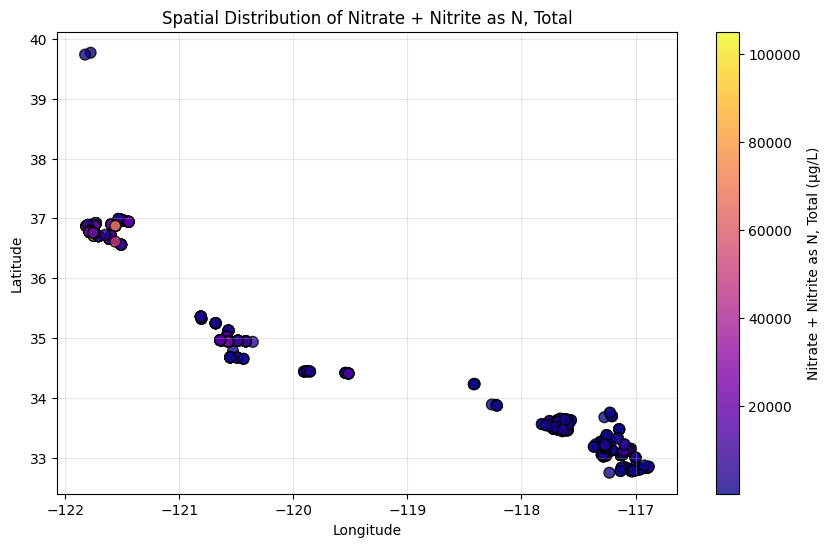

In [ ]:
plt.figure(figsize=(10, 6))
analyte_to_plot = "Nitrate + Nitrite as N, Total"  # change to one of your analytes

subset = df_clean_for_merge[(df_clean_for_merge['Analyte'] == analyte_to_plot) & (df_clean_for_merge['Latitude'] > 0)]

scatter = plt.scatter(
    subset['Longitude'],
    subset['Latitude'],
    c=subset['Result_ugL'],
    cmap='plasma',
    s=60,
    alpha=0.8,
    edgecolor='k'
)
plt.colorbar(scatter, label=f"{analyte_to_plot} (µg/L)")
plt.title(f"Spatial Distribution of {analyte_to_plot}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, alpha=0.3)
plt.show()

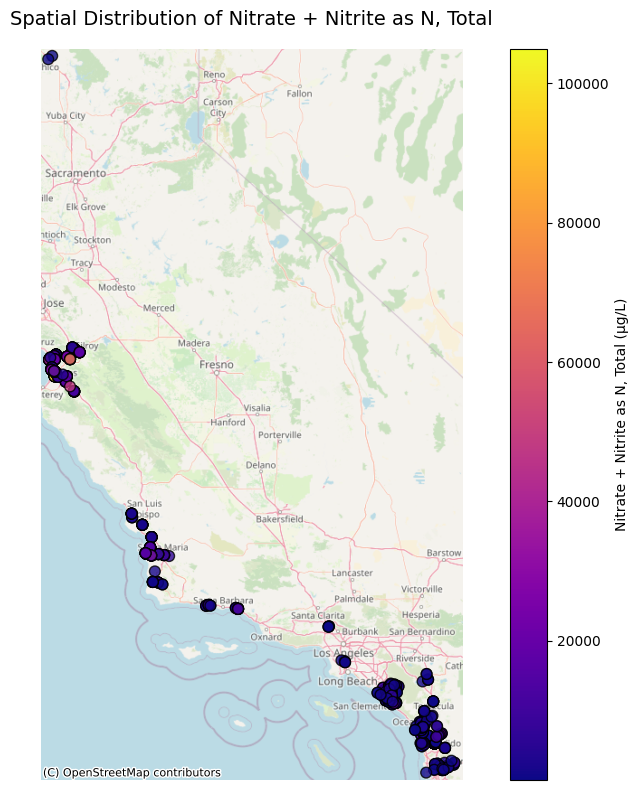

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Choose analyte to map
analyte_to_plot = "Nitrate + Nitrite as N, Total"

# Filter for valid coordinates
subset = df_clean_for_merge[
    (df_clean_for_merge['Analyte'] == analyte_to_plot) &
    (df_clean_for_merge['Latitude'] > 0) &
    (df_clean_for_merge['Longitude'] < 0)
].copy()

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    subset,
    geometry=gpd.points_from_xy(subset['Longitude'], subset['Latitude']),
    crs="EPSG:4326"  # lat/lon
)

# Convert to Web Mercator for basemap compatibility
gdf = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    ax=ax,
    column='Result_ugL',
    cmap='plasma',
    markersize=60,
    #norm=LogNorm(vmin=result_df['Result_ugL'].min()+1e-3, vmax=result_df['Result_ugL'].max()),
    alpha=0.8,
    edgecolor='k',
    legend=True,
    legend_kwds={'label': f"{analyte_to_plot} (µg/L)"}
)

# ✅ Add basemap (OpenStreetMap fallback)
try:
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.8)
except Exception as e:
    print(f"Basemap error ({e}), using default tiles.")
    ctx.add_basemap(ax, alpha=0.8)

# Zoom to data
ax.set_xlim(gdf.total_bounds[0] - 10000, gdf.total_bounds[2] + 10000)
ax.set_ylim(gdf.total_bounds[1] - 10000, gdf.total_bounds[3] + 10000)

# Style
ax.set_title(f"Spatial Distribution of {analyte_to_plot}", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()



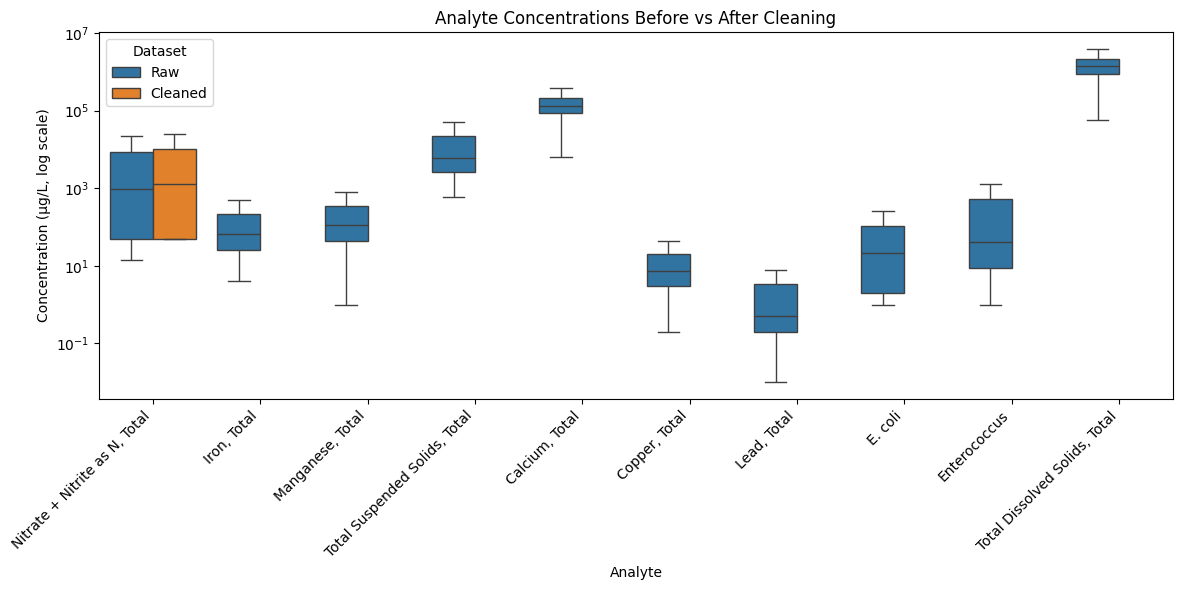

In [ ]:
df_results['Dataset'] = 'Raw'
df_clean_intermediate['Dataset'] = 'Cleaned'

df_compare = pd.concat([df_results, df_clean_final])

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_compare,
    x='Analyte',
    y='Result_ugL',
    hue='Dataset',
    showfliers=False  # hide extreme points for clarity
)
plt.yscale('log')
plt.title("Analyte Concentrations Before vs After Cleaning")
plt.ylabel("Concentration (µg/L, log scale)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

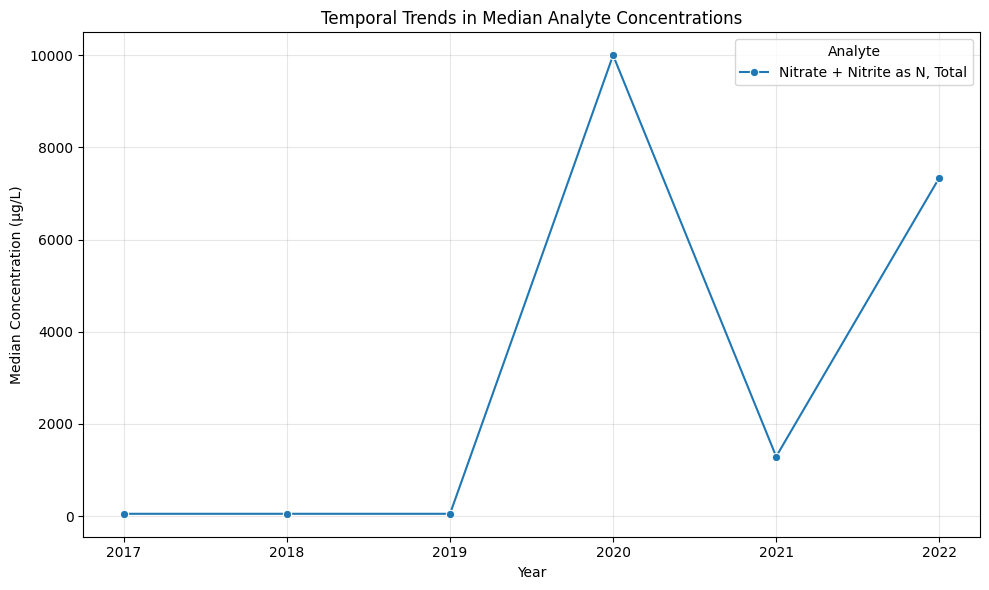

In [ ]:
df_time = (
    df_clean_final
    .groupby(['Year', 'Analyte'])
    ['Result_ugL']
    .median()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_time,
    x='Year',
    y='Result_ugL',
    hue='Analyte',
    marker='o'
)
plt.title("Temporal Trends in Median Analyte Concentrations")
plt.ylabel("Median Concentration (µg/L)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

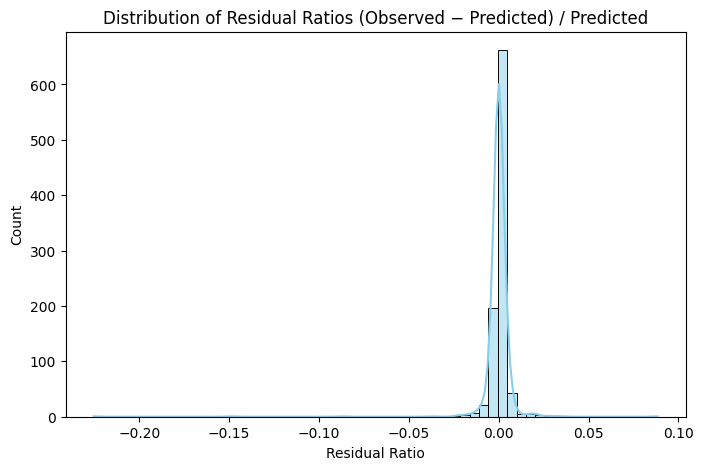

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_results['residual_ratio'], bins=60, color='skyblue', kde=True)
plt.title("Distribution of Residual Ratios (Observed − Predicted) / Predicted")
plt.xlabel("Residual Ratio")
plt.ylabel("Count")
plt.show()